In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import albumentations as A
import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image
from sklearn.utils import shuffle
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
%matplotlib inline

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LEARNING_RATE = 1e-3
BATCH_SIZE = 32
NUM_WORKERS = 2
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
PIN_MEMORY = True
LOAD_MODEL = True

In [2]:
DATA_PATH = "kaggle_3m/"

dirs = []
images = []
masks = []
for dirname, _, filenames in os.walk(DATA_PATH):
    for filename in filenames:
        if 'mask'in filename:
            dirs.append(dirname.replace(DATA_PATH, ''))
            masks.append(filename)
            images.append(filename.replace('_mask', ''))
print(DEVICE)

cuda


In [3]:
def is_all_zero(index):
    return np.all((np.array(Image.open(imagePath_df["mask-path"][index]).convert("L")).astype(np.float32) == 0))

In [4]:
"""
Data directory for the masks and images
Format is TCGA_<institution-code>_<patient-id>_<slice-number>.tif
Each image is a slice MRI scan of the patient's brain, with a mask showing tumor area if present
"""

imagePath_df = pd.DataFrame({'directory':dirs, 'images': images, 'masks': masks})
imagePath_df['image-path'] = DATA_PATH + imagePath_df['directory'] + '/' + imagePath_df['images']
imagePath_df['mask-path'] = DATA_PATH + imagePath_df['directory'] + '/' + imagePath_df['masks']

# Create an equal split of healthy and tumorous data images
healthy_df = pd.DataFrame()
tumor_df = pd.DataFrame()

for idx in range(len(imagePath_df)):
    if is_all_zero(idx):
        healthy_df = healthy_df.append(imagePath_df.loc[idx])
    else:
        tumor_df = tumor_df.append(imagePath_df.loc[idx])

train_healthy , test_healthy = train_test_split(healthy_df, test_size=0.15)
train_tumor , test_tumor = train_test_split(tumor_df, test_size=0.15)
train = shuffle(pd.concat([train_tumor, train_healthy]))
test = shuffle(pd.concat([test_tumor, test_healthy]))

In [5]:
# Show image shape
imagePath = os.path.join(DATA_PATH, imagePath_df['directory'].iloc[0], imagePath_df['images'].iloc[0])
maskPath = os.path.join(DATA_PATH, imagePath_df['directory'].iloc[0], imagePath_df['masks'].iloc[0])
image = cv2.imread(imagePath)
mask = cv2.imread(maskPath)

image.shape, mask.shape

((256, 256, 3), (256, 256, 3))

In [6]:
def plot_image(i):

    imagePath = os.path.join(DATA_PATH, imagePath_df['directory'].iloc[i], imagePath_df['images'].iloc[i])
    maskPath = os.path.join(DATA_PATH, imagePath_df['directory'].iloc[i], imagePath_df['masks'].iloc[i])
    
    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)
    
    fig, axs = plt.subplots(1,3, figsize=[13,15])
    
    axs[0].imshow(image)
    axs[0].set_title('Brain MRI')
    
    axs[1].imshow(mask)
    axs[1].set_title('Mask')
    
    axs[2].imshow(image)
    axs[2].imshow(mask, alpha=0.4)
    axs[2].set_title('MRI with mask')
    
    plt.grid(False)
    plt.show()

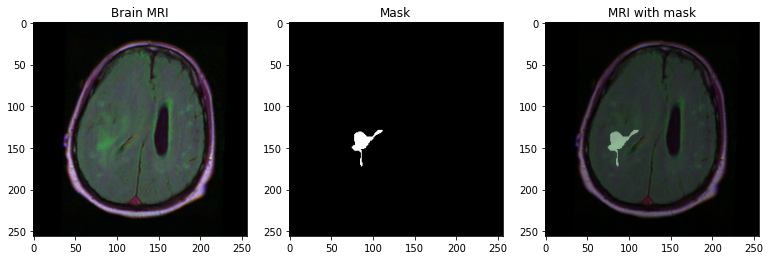

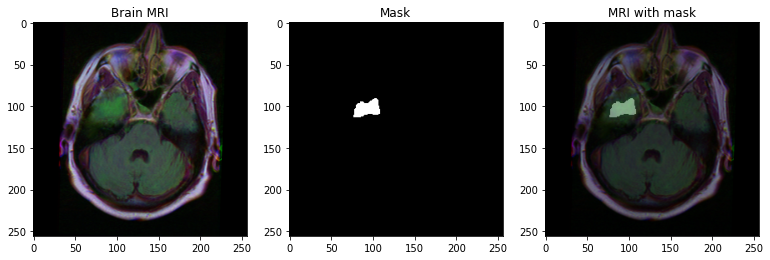

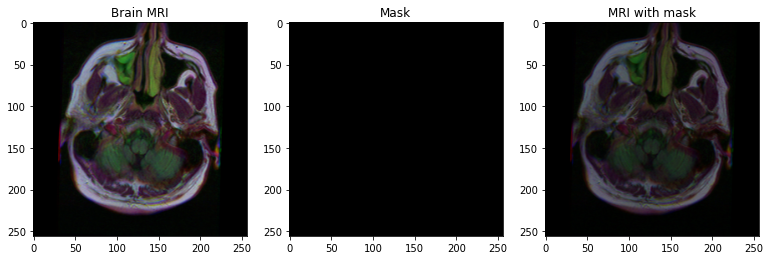

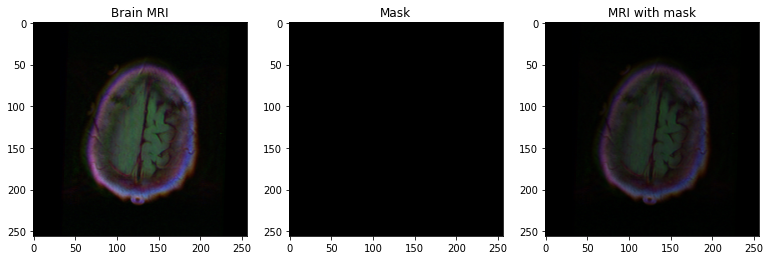

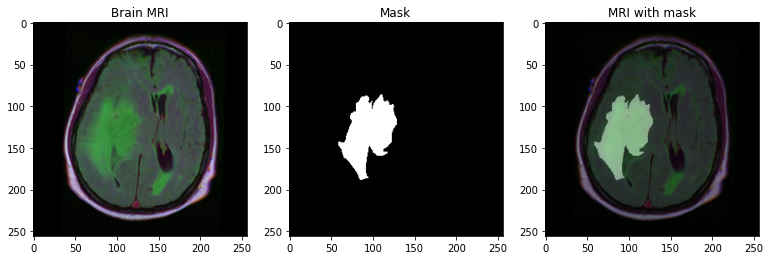

In [7]:
# Plot some example images
for i in range(5):
    plot_image(i)

In [8]:
# Training samples vs testing samples
len(train), len(test)

(3339, 590)

In [9]:
train

,directory,image-path,images,mask-path,masks
641,TCGA_DU_8165_19970205,kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_1...,TCGA_DU_8165_19970205_1.tif,kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_1...,TCGA_DU_8165_19970205_1_mask.tif
323,TCGA_DU_A5TP_19970614,kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_1...,TCGA_DU_A5TP_19970614_16.tif,kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_1...,TCGA_DU_A5TP_19970614_16_mask.tif
1528,TCGA_CS_4941_19960909,kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_1...,TCGA_CS_4941_19960909_14.tif,kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_1...,TCGA_CS_4941_19960909_14_mask.tif
1435,TCGA_HT_A61B_19991127,kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_1...,TCGA_HT_A61B_19991127_83.tif,kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_1...,TCGA_HT_A61B_19991127_83_mask.tif
3538,TCGA_HT_7879_19981009,kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_1...,TCGA_HT_7879_19981009_13.tif,kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_1...,TCGA_HT_7879_19981009_13_mask.tif
...,...,...,...,...,...
3290,TCGA_HT_8111_19980330,kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_1...,TCGA_HT_8111_19980330_5.tif,kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_1...,TCGA_HT_8111_19980330_5_mask.tif
1207,TCGA_DU_7010_19860307,kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_1...,TCGA_DU_7010_19860307_6.tif,kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_1...,TCGA_DU_7010_19860307_6_mask.tif
3912,TCGA_DU_A5TY_19970709,kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_1...,TCGA_DU_A5TY_19970709_33.tif,kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_1...,TCGA_DU_A5TY_19970709_33_mask.tif
205,TCGA_DU_7309_19960831,kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_1...,TCGA_DU_7309_19960831_6.tif,kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_1...,TCGA_DU_7309_19960831_6_mask.tif


In [10]:
test

,directory,image-path,images,mask-path,masks
3115,TCGA_CS_6186_20000601,kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_2...,TCGA_CS_6186_20000601_3.tif,kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_2...,TCGA_CS_6186_20000601_3_mask.tif
2691,TCGA_EZ_7264_20010816,kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_2...,TCGA_EZ_7264_20010816_8.tif,kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_2...,TCGA_EZ_7264_20010816_8_mask.tif
154,TCGA_FG_5962_20000626,kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_2...,TCGA_FG_5962_20000626_14.tif,kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_2...,TCGA_FG_5962_20000626_14_mask.tif
770,TCGA_HT_7680_19970202,kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_1...,TCGA_HT_7680_19970202_10.tif,kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_1...,TCGA_HT_7680_19970202_10_mask.tif
1813,TCGA_DU_6407_19860514,kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_1...,TCGA_DU_6407_19860514_13.tif,kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_1...,TCGA_DU_6407_19860514_13_mask.tif
...,...,...,...,...,...
3060,TCGA_DU_6400_19830518,kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_1...,TCGA_DU_6400_19830518_12.tif,kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_1...,TCGA_DU_6400_19830518_12_mask.tif
214,TCGA_FG_6688_20020215,kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_2...,TCGA_FG_6688_20020215_8.tif,kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_2...,TCGA_FG_6688_20020215_8_mask.tif
1407,TCGA_HT_A61B_19991127,kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_1...,TCGA_HT_A61B_19991127_11.tif,kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_1...,TCGA_HT_A61B_19991127_11_mask.tif
2035,TCGA_HT_8114_19981030,kaggle_3m/TCGA_HT_8114_19981030/TCGA_HT_8114_1...,TCGA_HT_8114_19981030_4.tif,kaggle_3m/TCGA_HT_8114_19981030/TCGA_HT_8114_1...,TCGA_HT_8114_19981030_4_mask.tif


In [11]:
class BrainMRIDataset(Dataset):
    def __init__(self, image_list, mask_list, transform=None):
        self.images = list(image_list)
        self.masks = list(mask_list)
        self.transform = transform
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = np.array(Image.open(self.images[index]).convert("RGB"))
        mask = np.array(Image.open(self.masks[index]).convert("L")).astype(np.float32)
        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

In [12]:
train_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

val_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

In [66]:
train_ds = BrainMRIDataset(
    image_list=list(train["image-path"]),
    mask_list=list(train["mask-path"]),
    transform=train_transform,
)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True,
)

val_ds = BrainMRIDataset(
    image_list=list(test["image-path"]),
    mask_list=list(test["mask-path"]),
    transform=val_transform,
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True,
)

Now we move on to defining the neural network, here is a basic network structure:
![UNet](UNet.png)

In [14]:
# First define the double convolution layer for u-net down
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

In [15]:
class UNET(nn.Module):
    def __init__(
        self, 
        in_channels=3, 
        out_channels=1, 
        features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))
        
        # Lowest layer connecting up and down processes
        self.bottom_u = DoubleConv(features[-1], features[-1]*2)
        
        # Final convolution layer to output
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottom_u(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [16]:
# Define unet and move to GPU
unet = UNET(in_channels = 3, out_channels = 1)
unet.to(DEVICE)
# Batch size 1, 3 color channels, 256x256 image
test_forward = unet(torch.randn((1, 3, 256, 256)).cuda())
test_forward.shape

torch.Size([1, 1, 256, 256])

In [17]:
# Define checkpoint saving

def save_checkpoint(state, filename="checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

In [18]:
def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )

    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )
    score = dice_score/len(loader)
    print(f"Dice score: {score}")
    model.train()
    return score

In [67]:
def generate_predictions(
    loader, model, device="cuda"
):
    model.eval()
    predictions = []
    for x, y in loader:
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float().cpu()
            predictions.append((preds, y))
    return predictions

In [20]:
def plot_image(predictions, index):
    
    fig, axs = plt.subplots(1,5, figsize=[13,15])
    
    axs[0].imshow(val_ds[index][0].permute(1, 2, 0))
    axs[0].set_title('Brain MRI')
    
    axs[1].imshow(predictions[0][1][index])
    axs[1].set_title('Tumor')
    
    axs[2].imshow(val_ds[index][0].permute(1, 2, 0))
    axs[2].imshow(predictions[0][1][index], alpha=0.4)
    axs[2].set_title('Brain with tumor')
    
    axs[4].imshow(predictions[0][0][index].permute(1, 2, 0))
    axs[4].set_title('Predicted tumor')
    
    axs[3].imshow(val_ds[index][0].permute(1, 2, 0))
    axs[3].imshow(predictions[0][0][index].permute(1, 2, 0), alpha=0.4)
    axs[3].set_title('Brain with predicted tumor')
    
    plt.grid(False)
    plt.show()

In [21]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(unet.parameters(), lr=LEARNING_RATE)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)
scaler = torch.cuda.amp.GradScaler()

In [22]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

In [23]:
score = 0
accuracy = []
learn_rate = []
worsen = 0
epochs = 0
# Train until we don't see improvement for 15 consequetive epochs
while worsen <= 20:
        train_fn(train_loader, unet, optimizer, loss_fn, scaler)

        # check accuracy
        new_score = check_accuracy(val_loader, unet, device=DEVICE)
        accuracy.append(new_score)
        print('Epoch {0} lr: {1}'.format(epochs+1, optimizer.param_groups[0]['lr']))
        
        if (new_score > score):
            print("Better model, saving...")
            worsen = 0
            # save model
            checkpoint = {
                "state_dict": unet.state_dict(),
                "optimizer":optimizer.state_dict(),
            }
            save_checkpoint(checkpoint)
            score = new_score
        else:
            scheduler.step()
            print("Worse model, skipping...")
            worsen += 1
            # Reset learning rate in an attempt to escape local minima
            if worsen == 5:
                optimizer = optim.Adam(unet.parameters(), lr=1e-3)
                scheduler = StepLR(optimizer, step_size=2, gamma=0.1)
        epochs += 1
        learn_rate.append(optimizer.param_groups[0]['lr'])

100%|██████████| 105/105 [00:23<00:00,  4.42it/s, loss=0.0619]


Got 38304147/38666240 with acc 99.06
Dice score: 0.43016317486763
Epoch 1 lr: 0.001
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.42it/s, loss=0.0433]


Got 38277334/38666240 with acc 98.99
Dice score: 0.5879374146461487
Epoch 2 lr: 0.001
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.41it/s, loss=0.0276]


Got 38453010/38666240 with acc 99.45
Dice score: 0.649264395236969
Epoch 3 lr: 0.001
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.42it/s, loss=0.0337]


Got 38461877/38666240 with acc 99.47
Dice score: 0.7084463834762573
Epoch 4 lr: 0.001
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38456695/38666240 with acc 99.46
Dice score: 0.7016002535820007
Epoch 5 lr: 0.001
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.41it/s, loss=0.0145] 


Got 38487445/38666240 with acc 99.54
Dice score: 0.7460296750068665
Epoch 6 lr: 0.001
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38441200/38666240 with acc 99.42
Dice score: 0.7137021422386169
Epoch 7 lr: 0.001
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.42it/s, loss=0.0209]


Got 38512097/38666240 with acc 99.60
Dice score: 0.778731107711792
Epoch 8 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.43it/s, loss=0.0161] 


Got 38521256/38666240 with acc 99.63
Dice score: 0.7870141863822937
Epoch 9 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.44it/s, loss=0.00929]


Got 38527516/38666240 with acc 99.64
Dice score: 0.7993658781051636
Epoch 10 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.41it/s, loss=0.00962]


Got 38534433/38666240 with acc 99.66
Dice score: 0.814519464969635
Epoch 11 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.42it/s, loss=0.0105] 


Got 38538118/38666240 with acc 99.67
Dice score: 0.8236787915229797
Epoch 12 lr: 0.0001
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38542464/38666240 with acc 99.68
Dice score: 0.8229674100875854
Epoch 13 lr: 0.0001
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.40it/s, loss=0.0304] 


Got 38546056/38666240 with acc 99.69
Dice score: 0.8368061780929565
Epoch 14 lr: 0.0001
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38544971/38666240 with acc 99.69
Dice score: 0.8260060548782349
Epoch 15 lr: 0.0001
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.43it/s, loss=0.00838]


Got 38552971/38666240 with acc 99.71
Dice score: 0.8424877524375916
Epoch 16 lr: 1e-05
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.41it/s, loss=0.0107] 


Got 38553774/38666240 with acc 99.71
Dice score: 0.847062349319458
Epoch 17 lr: 1e-05
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.42it/s, loss=0.00762]


Got 38553876/38666240 with acc 99.71
Dice score: 0.8475862741470337
Epoch 18 lr: 1e-05
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38553317/38666240 with acc 99.71
Dice score: 0.8449617624282837
Epoch 19 lr: 1e-05
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.41it/s, loss=0.0102] 


Got 38554157/38666240 with acc 99.71
Dice score: 0.8484418988227844
Epoch 20 lr: 1e-05
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.41it/s, loss=0.0108] 


Got 38554958/38666240 with acc 99.71
Dice score: 0.8485924601554871
Epoch 21 lr: 1e-05
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38554789/38666240 with acc 99.71
Dice score: 0.8459473848342896
Epoch 22 lr: 1e-05
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.42it/s, loss=0.0119] 


Got 38554847/38666240 with acc 99.71
Dice score: 0.8496728539466858
Epoch 23 lr: 1.0000000000000002e-06
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38555051/38666240 with acc 99.71
Dice score: 0.848785936832428
Epoch 24 lr: 1.0000000000000002e-06
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.39it/s, loss=0.00843]


Got 38555472/38666240 with acc 99.71
Dice score: 0.8505963683128357
Epoch 25 lr: 1.0000000000000002e-06
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.41it/s, loss=0.0078] 


Got 38553748/38666240 with acc 99.71
Dice score: 0.851059079170227
Epoch 26 lr: 1.0000000000000002e-06
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38554146/38666240 with acc 99.71
Dice score: 0.8507405519485474
Epoch 27 lr: 1.0000000000000002e-06
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38554578/38666240 with acc 99.71
Dice score: 0.8452032208442688
Epoch 28 lr: 1.0000000000000002e-07
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38554985/38666240 with acc 99.71
Dice score: 0.8492519855499268
Epoch 29 lr: 1.0000000000000002e-07
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38555026/38666240 with acc 99.71
Dice score: 0.8498316407203674
Epoch 30 lr: 1.0000000000000004e-08
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38554998/38666240 with acc 99.71
Dice score: 0.848366916179657
Epoch 31 lr: 1.0000000000000004e-08
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38506315/38666240 with acc 99.59
Dice score: 0.7560418248176575
Epoch 32 lr: 0.001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38499645/38666240 with acc 99.57
Dice score: 0.7350923418998718
Epoch 33 lr: 0.001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38550028/38666240 with acc 99.70
Dice score: 0.8405711054801941
Epoch 34 lr: 0.0001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38542340/38666240 with acc 99.68
Dice score: 0.8375463485717773
Epoch 35 lr: 0.0001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38555548/38666240 with acc 99.71
Dice score: 0.8506253957748413
Epoch 36 lr: 1e-05
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38555993/38666240 with acc 99.71
Dice score: 0.8497847318649292
Epoch 37 lr: 1e-05
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38556044/38666240 with acc 99.72
Dice score: 0.8505969047546387
Epoch 38 lr: 1.0000000000000002e-06
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.41it/s, loss=0.00836]


Got 38556203/38666240 with acc 99.72
Dice score: 0.8529737591743469
Epoch 39 lr: 1.0000000000000002e-06
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38556879/38666240 with acc 99.72
Dice score: 0.8513461947441101
Epoch 40 lr: 1.0000000000000002e-06
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38556613/38666240 with acc 99.72
Dice score: 0.8516261577606201
Epoch 41 lr: 1.0000000000000002e-07
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38556915/38666240 with acc 99.72
Dice score: 0.8518357872962952
Epoch 42 lr: 1.0000000000000002e-07
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38556709/38666240 with acc 99.72
Dice score: 0.8511040210723877
Epoch 43 lr: 1.0000000000000004e-08
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38555713/38666240 with acc 99.71
Dice score: 0.8519439697265625
Epoch 44 lr: 1.0000000000000004e-08
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38530303/38666240 with acc 99.65
Dice score: 0.8035081624984741
Epoch 45 lr: 0.001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38540288/38666240 with acc 99.67
Dice score: 0.8181708455085754
Epoch 46 lr: 0.001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38558709/38666240 with acc 99.72
Dice score: 0.8510642647743225
Epoch 47 lr: 0.0001
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.40it/s, loss=0.00306]


Got 38562062/38666240 with acc 99.73
Dice score: 0.8558061718940735
Epoch 48 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.42it/s, loss=0.00432]


Got 38563637/38666240 with acc 99.73
Dice score: 0.8622322082519531
Epoch 49 lr: 0.0001
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38565003/38666240 with acc 99.74
Dice score: 0.8572984337806702
Epoch 50 lr: 0.0001
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.41it/s, loss=0.00665]


Got 38567379/38666240 with acc 99.74
Dice score: 0.8656714558601379
Epoch 51 lr: 1e-05
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.40it/s, loss=0.00935]


Got 38568225/38666240 with acc 99.75
Dice score: 0.8664559721946716
Epoch 52 lr: 1e-05
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.42it/s, loss=0.00966]


Got 38567664/38666240 with acc 99.75
Dice score: 0.8674020171165466
Epoch 53 lr: 1e-05
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38568252/38666240 with acc 99.75
Dice score: 0.8670054078102112
Epoch 54 lr: 1e-05
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38568629/38666240 with acc 99.75
Dice score: 0.8654876351356506
Epoch 55 lr: 1e-05
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.40it/s, loss=0.0108] 


Got 38568908/38666240 with acc 99.75
Dice score: 0.8680952191352844
Epoch 56 lr: 1.0000000000000002e-06
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.42it/s, loss=0.00602]


Got 38568502/38666240 with acc 99.75
Dice score: 0.8682416677474976
Epoch 57 lr: 1.0000000000000002e-06
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38568734/38666240 with acc 99.75
Dice score: 0.8669772148132324
Epoch 58 lr: 1.0000000000000002e-06
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38568824/38666240 with acc 99.75
Dice score: 0.8667159080505371
Epoch 59 lr: 1.0000000000000002e-06
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.40it/s, loss=0.00392]


Got 38568502/38666240 with acc 99.75
Dice score: 0.8683474659919739
Epoch 60 lr: 1.0000000000000002e-07
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38568872/38666240 with acc 99.75
Dice score: 0.8666525483131409
Epoch 61 lr: 1.0000000000000002e-07
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38568756/38666240 with acc 99.75
Dice score: 0.8670789003372192
Epoch 62 lr: 1.0000000000000002e-07
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38568801/38666240 with acc 99.75
Dice score: 0.8656595945358276
Epoch 63 lr: 1.0000000000000004e-08
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38568713/38666240 with acc 99.75
Dice score: 0.8675612211227417
Epoch 64 lr: 1.0000000000000004e-08
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.39it/s, loss=0.00431]


Got 38568585/38666240 with acc 99.75
Dice score: 0.8693950176239014
Epoch 65 lr: 1.0000000000000005e-09
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38568699/38666240 with acc 99.75
Dice score: 0.8652270436286926
Epoch 66 lr: 1.0000000000000005e-09
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38568383/38666240 with acc 99.75
Dice score: 0.8686457276344299
Epoch 67 lr: 1.0000000000000005e-09
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38568815/38666240 with acc 99.75
Dice score: 0.867053210735321
Epoch 68 lr: 1.0000000000000006e-10
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38567919/38666240 with acc 99.75
Dice score: 0.8691580891609192
Epoch 69 lr: 1.0000000000000006e-10
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38568744/38666240 with acc 99.75
Dice score: 0.8666773438453674
Epoch 70 lr: 1.0000000000000006e-11
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38510320/38666240 with acc 99.60
Dice score: 0.7637298107147217
Epoch 71 lr: 0.001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38491970/38666240 with acc 99.55
Dice score: 0.7320075631141663
Epoch 72 lr: 0.001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38568470/38666240 with acc 99.75
Dice score: 0.8622948527336121
Epoch 73 lr: 0.0001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38571322/38666240 with acc 99.75
Dice score: 0.8688418865203857
Epoch 74 lr: 0.0001
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.42it/s, loss=0.0111] 


Got 38571604/38666240 with acc 99.76
Dice score: 0.8696159720420837
Epoch 75 lr: 1e-05
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.39it/s, loss=0.005]  


Got 38572343/38666240 with acc 99.76
Dice score: 0.8731149435043335
Epoch 76 lr: 1e-05
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38572769/38666240 with acc 99.76
Dice score: 0.8725243806838989
Epoch 77 lr: 1e-05
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.40it/s, loss=0.00458]


Got 38573061/38666240 with acc 99.76
Dice score: 0.8740587830543518
Epoch 78 lr: 1e-05
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38573594/38666240 with acc 99.76
Dice score: 0.8733665943145752
Epoch 79 lr: 1e-05
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.41it/s, loss=0.0107] 


Got 38574129/38666240 with acc 99.76
Dice score: 0.874832034111023
Epoch 80 lr: 1.0000000000000002e-06
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.40it/s, loss=0.00527]


Got 38573716/38666240 with acc 99.76
Dice score: 0.8751043081283569
Epoch 81 lr: 1.0000000000000002e-06
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38573997/38666240 with acc 99.76
Dice score: 0.8750934600830078
Epoch 82 lr: 1.0000000000000002e-06
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38573520/38666240 with acc 99.76
Dice score: 0.8728013634681702
Epoch 83 lr: 1.0000000000000002e-06
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.40it/s, loss=0.00456]


Got 38573666/38666240 with acc 99.76
Dice score: 0.8760515451431274
Epoch 84 lr: 1.0000000000000002e-07
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38573906/38666240 with acc 99.76
Dice score: 0.8742991089820862
Epoch 85 lr: 1.0000000000000002e-07
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38573558/38666240 with acc 99.76
Dice score: 0.8759122490882874
Epoch 86 lr: 1.0000000000000002e-07
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38573962/38666240 with acc 99.76
Dice score: 0.8738356232643127
Epoch 87 lr: 1.0000000000000004e-08
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38573826/38666240 with acc 99.76
Dice score: 0.8743302226066589
Epoch 88 lr: 1.0000000000000004e-08
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38574006/38666240 with acc 99.76
Dice score: 0.8741676807403564
Epoch 89 lr: 1.0000000000000005e-09
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38548574/38666240 with acc 99.70
Dice score: 0.8499148488044739
Epoch 90 lr: 0.001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38548836/38666240 with acc 99.70
Dice score: 0.8452821969985962
Epoch 91 lr: 0.001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38573626/38666240 with acc 99.76
Dice score: 0.8731595873832703
Epoch 92 lr: 0.0001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38575429/38666240 with acc 99.77
Dice score: 0.8733888268470764
Epoch 93 lr: 0.0001
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.41it/s, loss=0.00493]


Got 38576926/38666240 with acc 99.77
Dice score: 0.8802547454833984
Epoch 94 lr: 1e-05
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.41it/s, loss=0.00522]


Got 38576993/38666240 with acc 99.77
Dice score: 0.8806093335151672
Epoch 95 lr: 1e-05
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.38it/s, loss=0.0006] 


Got 38577284/38666240 with acc 99.77
Dice score: 0.8806599974632263
Epoch 96 lr: 1e-05
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.39it/s, loss=0.00642]


Got 38577615/38666240 with acc 99.77
Dice score: 0.8809319734573364
Epoch 97 lr: 1e-05
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38578162/38666240 with acc 99.77
Dice score: 0.8806008696556091
Epoch 98 lr: 1e-05
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.40it/s, loss=0.00805]


Got 38578239/38666240 with acc 99.77
Dice score: 0.8816482424736023
Epoch 99 lr: 1e-05
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.40it/s, loss=0.00289]


Got 38578526/38666240 with acc 99.77
Dice score: 0.8823534250259399
Epoch 100 lr: 1e-05
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.40it/s, loss=0.00508]


Got 38578462/38666240 with acc 99.77
Dice score: 0.8829099535942078
Epoch 101 lr: 1e-05
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38579138/38666240 with acc 99.77
Dice score: 0.8825932741165161
Epoch 102 lr: 1e-05
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38578817/38666240 with acc 99.77
Dice score: 0.8828523755073547
Epoch 103 lr: 1.0000000000000002e-06
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38578817/38666240 with acc 99.77
Dice score: 0.8807956576347351
Epoch 104 lr: 1.0000000000000002e-06
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.38it/s, loss=0.00213]


Got 38578721/38666240 with acc 99.77
Dice score: 0.8831350207328796
Epoch 105 lr: 1.0000000000000002e-07
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38578854/38666240 with acc 99.77
Dice score: 0.8819587230682373
Epoch 106 lr: 1.0000000000000002e-07
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38578886/38666240 with acc 99.77
Dice score: 0.8817563652992249
Epoch 107 lr: 1.0000000000000002e-07
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38578994/38666240 with acc 99.77
Dice score: 0.8817288279533386
Epoch 108 lr: 1.0000000000000004e-08
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38578669/38666240 with acc 99.77
Dice score: 0.8827843070030212
Epoch 109 lr: 1.0000000000000004e-08
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38578280/38666240 with acc 99.77
Dice score: 0.87859708070755
Epoch 110 lr: 1.0000000000000005e-09
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38565031/38666240 with acc 99.74
Dice score: 0.8505104780197144
Epoch 111 lr: 0.001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38568067/38666240 with acc 99.75
Dice score: 0.8599605560302734
Epoch 112 lr: 0.001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38579624/38666240 with acc 99.78
Dice score: 0.8780957460403442
Epoch 113 lr: 0.0001
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.40it/s, loss=0.00757]


Got 38583343/38666240 with acc 99.79
Dice score: 0.8869509696960449
Epoch 114 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.41it/s, loss=0.00455]


Got 38583331/38666240 with acc 99.79
Dice score: 0.8885122537612915
Epoch 115 lr: 0.0001
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38583364/38666240 with acc 99.79
Dice score: 0.8852741718292236
Epoch 116 lr: 0.0001
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.40it/s, loss=0.00463]


Got 38585169/38666240 with acc 99.79
Dice score: 0.8898797631263733
Epoch 117 lr: 1e-05
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.39it/s, loss=0.00692]


Got 38585761/38666240 with acc 99.79
Dice score: 0.8905800580978394
Epoch 118 lr: 1e-05
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.41it/s, loss=0.0106] 


Got 38585508/38666240 with acc 99.79
Dice score: 0.8913553357124329
Epoch 119 lr: 1e-05
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38584859/38666240 with acc 99.79
Dice score: 0.8874691724777222
Epoch 120 lr: 1e-05
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38585821/38666240 with acc 99.79
Dice score: 0.8906149864196777
Epoch 121 lr: 1e-05
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38585609/38666240 with acc 99.79
Dice score: 0.8901422619819641
Epoch 122 lr: 1.0000000000000002e-06
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.40it/s, loss=0.00496]


Got 38585860/38666240 with acc 99.79
Dice score: 0.8917710185050964
Epoch 123 lr: 1.0000000000000002e-06
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38585975/38666240 with acc 99.79
Dice score: 0.8909865021705627
Epoch 124 lr: 1.0000000000000002e-06
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38585873/38666240 with acc 99.79
Dice score: 0.8914221525192261
Epoch 125 lr: 1.0000000000000002e-07
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38585844/38666240 with acc 99.79
Dice score: 0.8899579644203186
Epoch 126 lr: 1.0000000000000002e-07
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.40it/s, loss=0.00184]


Got 38585777/38666240 with acc 99.79
Dice score: 0.8919560313224792
Epoch 127 lr: 1.0000000000000004e-08
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38585757/38666240 with acc 99.79
Dice score: 0.8913419842720032
Epoch 128 lr: 1.0000000000000004e-08
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38585832/38666240 with acc 99.79
Dice score: 0.8916633129119873
Epoch 129 lr: 1.0000000000000004e-08
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38585700/38666240 with acc 99.79
Dice score: 0.8910729289054871
Epoch 130 lr: 1.0000000000000005e-09
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38586084/38666240 with acc 99.79
Dice score: 0.8917451500892639
Epoch 131 lr: 1.0000000000000005e-09
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38585918/38666240 with acc 99.79
Dice score: 0.8912017345428467
Epoch 132 lr: 1.0000000000000006e-10
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38552266/38666240 with acc 99.71
Dice score: 0.8326656818389893
Epoch 133 lr: 0.001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38559214/38666240 with acc 99.72
Dice score: 0.8633332848548889
Epoch 134 lr: 0.001
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.39it/s, loss=0.00276]


Got 38587268/38666240 with acc 99.80
Dice score: 0.8933337330818176
Epoch 135 lr: 0.0001
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38584673/38666240 with acc 99.79
Dice score: 0.8873946666717529
Epoch 136 lr: 0.0001
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.39it/s, loss=0.0107] 


Got 38588300/38666240 with acc 99.80
Dice score: 0.8941280245780945
Epoch 137 lr: 0.0001
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38586312/38666240 with acc 99.79
Dice score: 0.8926264047622681
Epoch 138 lr: 0.0001
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.38it/s, loss=0.00446]


Got 38588493/38666240 with acc 99.80
Dice score: 0.8949125409126282
Epoch 139 lr: 1e-05
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.40it/s, loss=0.00562]


Got 38588529/38666240 with acc 99.80
Dice score: 0.8962406516075134
Epoch 140 lr: 1e-05
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38589143/38666240 with acc 99.80
Dice score: 0.8956974744796753
Epoch 141 lr: 1e-05
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38588883/38666240 with acc 99.80
Dice score: 0.8961825370788574
Epoch 142 lr: 1e-05
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38588779/38666240 with acc 99.80
Dice score: 0.8959648013114929
Epoch 143 lr: 1.0000000000000002e-06
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.39it/s, loss=0.00305]


Got 38588730/38666240 with acc 99.80
Dice score: 0.8965926170349121
Epoch 144 lr: 1.0000000000000002e-06
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38589107/38666240 with acc 99.80
Dice score: 0.8962612152099609
Epoch 145 lr: 1.0000000000000002e-06
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38589067/38666240 with acc 99.80
Dice score: 0.8962622284889221
Epoch 146 lr: 1.0000000000000002e-07
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38587971/38666240 with acc 99.80
Dice score: 0.895432710647583
Epoch 147 lr: 1.0000000000000002e-07
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38589511/38666240 with acc 99.80
Dice score: 0.8961396813392639
Epoch 148 lr: 1.0000000000000004e-08
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38589027/38666240 with acc 99.80
Dice score: 0.8965138792991638
Epoch 149 lr: 1.0000000000000004e-08
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38553026/38666240 with acc 99.71
Dice score: 0.8403667211532593
Epoch 150 lr: 0.001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38548901/38666240 with acc 99.70
Dice score: 0.8534762859344482
Epoch 151 lr: 0.001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38590166/38666240 with acc 99.80
Dice score: 0.8963332772254944
Epoch 152 lr: 0.0001
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.41it/s, loss=0.00429]


Got 38590782/38666240 with acc 99.80
Dice score: 0.8990902304649353
Epoch 153 lr: 0.0001
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38591639/38666240 with acc 99.81
Dice score: 0.8981098532676697
Epoch 154 lr: 0.0001
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.38it/s, loss=0.00753]


Got 38592148/38666240 with acc 99.81
Dice score: 0.8991966247558594
Epoch 155 lr: 1e-05
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.39it/s, loss=0.00113]


Got 38591758/38666240 with acc 99.81
Dice score: 0.8999391794204712
Epoch 156 lr: 1e-05
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.38it/s, loss=0.00436]


Got 38592543/38666240 with acc 99.81
Dice score: 0.9003475904464722
Epoch 157 lr: 1e-05
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.38it/s, loss=0.00324]


Got 38592571/38666240 with acc 99.81
Dice score: 0.9003587961196899
Epoch 158 lr: 1e-05
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.38it/s, loss=0.0076] 


Got 38592725/38666240 with acc 99.81
Dice score: 0.9007390737533569
Epoch 159 lr: 1e-05
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38592503/38666240 with acc 99.81
Dice score: 0.9003576040267944
Epoch 160 lr: 1e-05
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38592810/38666240 with acc 99.81
Dice score: 0.9005319476127625
Epoch 161 lr: 1e-05
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.40it/s, loss=0.00642]


Got 38592858/38666240 with acc 99.81
Dice score: 0.9009318351745605
Epoch 162 lr: 1.0000000000000002e-06
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38592591/38666240 with acc 99.81
Dice score: 0.9009222984313965
Epoch 163 lr: 1.0000000000000002e-06
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.41it/s, loss=0.00783]


Got 38592831/38666240 with acc 99.81
Dice score: 0.9011327028274536
Epoch 164 lr: 1.0000000000000002e-06
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38592908/38666240 with acc 99.81
Dice score: 0.9009126424789429
Epoch 165 lr: 1.0000000000000002e-06
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38593046/38666240 with acc 99.81
Dice score: 0.9008519053459167
Epoch 166 lr: 1.0000000000000002e-07
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38592651/38666240 with acc 99.81
Dice score: 0.9008117318153381
Epoch 167 lr: 1.0000000000000002e-07
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38592859/38666240 with acc 99.81
Dice score: 0.9009668231010437
Epoch 168 lr: 1.0000000000000004e-08
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38592691/38666240 with acc 99.81
Dice score: 0.9002678394317627
Epoch 169 lr: 1.0000000000000004e-08
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38576354/38666240 with acc 99.77
Dice score: 0.8822299838066101
Epoch 170 lr: 0.001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38578979/38666240 with acc 99.77
Dice score: 0.8858849406242371
Epoch 171 lr: 0.001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38591357/38666240 with acc 99.81
Dice score: 0.9000158905982971
Epoch 172 lr: 0.0001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38591981/38666240 with acc 99.81
Dice score: 0.9011171460151672
Epoch 173 lr: 0.0001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38592027/38666240 with acc 99.81
Dice score: 0.9008196592330933
Epoch 174 lr: 1e-05
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.39it/s, loss=0.016]  


Got 38593309/38666240 with acc 99.81
Dice score: 0.9016124606132507
Epoch 175 lr: 1e-05
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.39it/s, loss=0.00624]


Got 38593277/38666240 with acc 99.81
Dice score: 0.9018484354019165
Epoch 176 lr: 1e-05
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38592941/38666240 with acc 99.81
Dice score: 0.9018226265907288
Epoch 177 lr: 1e-05
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38591593/38666240 with acc 99.81
Dice score: 0.9002767205238342
Epoch 178 lr: 1.0000000000000002e-06
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38592555/38666240 with acc 99.81
Dice score: 0.9015693664550781
Epoch 179 lr: 1.0000000000000002e-06
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38592228/38666240 with acc 99.81
Dice score: 0.9013274312019348
Epoch 180 lr: 1.0000000000000002e-07
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38592473/38666240 with acc 99.81
Dice score: 0.9015891551971436
Epoch 181 lr: 1.0000000000000002e-07
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38570306/38666240 with acc 99.75
Dice score: 0.8681346774101257
Epoch 182 lr: 0.001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38565717/38666240 with acc 99.74
Dice score: 0.8736605644226074
Epoch 183 lr: 0.001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38593933/38666240 with acc 99.81
Dice score: 0.9014155864715576
Epoch 184 lr: 0.0001
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.41it/s, loss=0.00085]


Got 38594634/38666240 with acc 99.81
Dice score: 0.9030224680900574
Epoch 185 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.40it/s, loss=0.00247]


Got 38595015/38666240 with acc 99.82
Dice score: 0.9038639068603516
Epoch 186 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.40it/s, loss=0.00343]


Got 38595437/38666240 with acc 99.82
Dice score: 0.9049302339553833
Epoch 187 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.39it/s, loss=0.00596]


Got 38595272/38666240 with acc 99.82
Dice score: 0.9052355885505676
Epoch 188 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.40it/s, loss=0.00342]


Got 38595946/38666240 with acc 99.82
Dice score: 0.9061427712440491
Epoch 189 lr: 0.0001
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38594928/38666240 with acc 99.82
Dice score: 0.9053738117218018
Epoch 190 lr: 0.0001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38595849/38666240 with acc 99.82
Dice score: 0.9053524732589722
Epoch 191 lr: 1e-05
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38595741/38666240 with acc 99.82
Dice score: 0.9054238200187683
Epoch 192 lr: 1e-05
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38595798/38666240 with acc 99.82
Dice score: 0.9051451683044434
Epoch 193 lr: 1.0000000000000002e-06
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38595559/38666240 with acc 99.82
Dice score: 0.9054274559020996
Epoch 194 lr: 1.0000000000000002e-06
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38583453/38666240 with acc 99.79
Dice score: 0.8861377239227295
Epoch 195 lr: 0.001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38571311/38666240 with acc 99.75
Dice score: 0.8803409934043884
Epoch 196 lr: 0.001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38596445/38666240 with acc 99.82
Dice score: 0.9057978391647339
Epoch 197 lr: 0.0001
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.39it/s, loss=0.00156]


Got 38597079/38666240 with acc 99.82
Dice score: 0.9062053561210632
Epoch 198 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.40it/s, loss=0.00342]


Got 38596558/38666240 with acc 99.82
Dice score: 0.9066069722175598
Epoch 199 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.38it/s, loss=0.00394]


Got 38596800/38666240 with acc 99.82
Dice score: 0.9066436290740967
Epoch 200 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.40it/s, loss=0.00486]


Got 38597668/38666240 with acc 99.82
Dice score: 0.9072813987731934
Epoch 201 lr: 0.0001
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38597402/38666240 with acc 99.82
Dice score: 0.9067978262901306
Epoch 202 lr: 0.0001
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.39it/s, loss=0.000548]


Got 38598001/38666240 with acc 99.82
Dice score: 0.9087651968002319
Epoch 203 lr: 1e-05
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.39it/s, loss=0.00753]


Got 38598069/38666240 with acc 99.82
Dice score: 0.9088339805603027
Epoch 204 lr: 1e-05
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38597355/38666240 with acc 99.82
Dice score: 0.9077519774436951
Epoch 205 lr: 1e-05
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38597659/38666240 with acc 99.82
Dice score: 0.9082462787628174
Epoch 206 lr: 1e-05
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38598124/38666240 with acc 99.82
Dice score: 0.9084732532501221
Epoch 207 lr: 1.0000000000000002e-06
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38597484/38666240 with acc 99.82
Dice score: 0.9080638885498047
Epoch 208 lr: 1.0000000000000002e-06
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38597806/38666240 with acc 99.82
Dice score: 0.9085291624069214
Epoch 209 lr: 1.0000000000000002e-07
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38590409/38666240 with acc 99.80
Dice score: 0.8967329263687134
Epoch 210 lr: 0.001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38575930/38666240 with acc 99.77
Dice score: 0.8720807433128357
Epoch 211 lr: 0.001
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.38it/s, loss=0.00101]


Got 38598827/38666240 with acc 99.83
Dice score: 0.9091958403587341
Epoch 212 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.39it/s, loss=0.00279]


Got 38598978/38666240 with acc 99.83
Dice score: 0.9105690717697144
Epoch 213 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:24<00:00,  4.36it/s, loss=0.00483]


Got 38599148/38666240 with acc 99.83
Dice score: 0.9106699228286743
Epoch 214 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.40it/s, loss=0.00419]


Got 38600042/38666240 with acc 99.83
Dice score: 0.9112010598182678
Epoch 215 lr: 0.0001
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38599190/38666240 with acc 99.83
Dice score: 0.9101239442825317
Epoch 216 lr: 0.0001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38600058/38666240 with acc 99.83
Dice score: 0.9111067056655884
Epoch 217 lr: 0.0001
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.40it/s, loss=0.00226]


Got 38600158/38666240 with acc 99.83
Dice score: 0.911401629447937
Epoch 218 lr: 1e-05
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.39it/s, loss=0.004]  


Got 38600135/38666240 with acc 99.83
Dice score: 0.9115281701087952
Epoch 219 lr: 1e-05
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38600203/38666240 with acc 99.83
Dice score: 0.9113832116127014
Epoch 220 lr: 1e-05
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38600012/38666240 with acc 99.83
Dice score: 0.9114890098571777
Epoch 221 lr: 1e-05
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.40it/s, loss=0.00329]


Got 38600090/38666240 with acc 99.83
Dice score: 0.9116247892379761
Epoch 222 lr: 1.0000000000000002e-06
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38600059/38666240 with acc 99.83
Dice score: 0.911475419998169
Epoch 223 lr: 1.0000000000000002e-06
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.39it/s, loss=0.00286]


Got 38600075/38666240 with acc 99.83
Dice score: 0.9116376638412476
Epoch 224 lr: 1.0000000000000002e-06
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.39it/s, loss=0.00476]


Got 38600189/38666240 with acc 99.83
Dice score: 0.9117023944854736
Epoch 225 lr: 1.0000000000000002e-06
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38600245/38666240 with acc 99.83
Dice score: 0.9114991426467896
Epoch 226 lr: 1.0000000000000002e-06
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38600143/38666240 with acc 99.83
Dice score: 0.911651611328125
Epoch 227 lr: 1.0000000000000002e-07
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38600120/38666240 with acc 99.83
Dice score: 0.9113281965255737
Epoch 228 lr: 1.0000000000000002e-07
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38600188/38666240 with acc 99.83
Dice score: 0.9116097688674927
Epoch 229 lr: 1.0000000000000004e-08
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38599945/38666240 with acc 99.83
Dice score: 0.911436915397644
Epoch 230 lr: 1.0000000000000004e-08
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38596064/38666240 with acc 99.82
Dice score: 0.9074729084968567
Epoch 231 lr: 0.001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38589728/38666240 with acc 99.80
Dice score: 0.8950945138931274
Epoch 232 lr: 0.001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38599639/38666240 with acc 99.83
Dice score: 0.9109286069869995
Epoch 233 lr: 0.0001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38599653/38666240 with acc 99.83
Dice score: 0.9111718535423279
Epoch 234 lr: 0.0001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38600043/38666240 with acc 99.83
Dice score: 0.9116109609603882
Epoch 235 lr: 1e-05
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38600294/38666240 with acc 99.83
Dice score: 0.9116670489311218
Epoch 236 lr: 1e-05
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.38it/s, loss=0.00322]


Got 38600262/38666240 with acc 99.83
Dice score: 0.9117956757545471
Epoch 237 lr: 1.0000000000000002e-06
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.39it/s, loss=0.000442]


Got 38600302/38666240 with acc 99.83
Dice score: 0.9118555188179016
Epoch 238 lr: 1.0000000000000002e-06
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.38it/s, loss=0.00472]


Got 38600248/38666240 with acc 99.83
Dice score: 0.9119170308113098
Epoch 239 lr: 1.0000000000000002e-06
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38600104/38666240 with acc 99.83
Dice score: 0.911641001701355
Epoch 240 lr: 1.0000000000000002e-06
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.38it/s, loss=0.00434]


Got 38600451/38666240 with acc 99.83
Dice score: 0.9120025634765625
Epoch 241 lr: 1.0000000000000002e-06
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38599908/38666240 with acc 99.83
Dice score: 0.9116355776786804
Epoch 242 lr: 1.0000000000000002e-06
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38600339/38666240 with acc 99.83
Dice score: 0.9119116067886353
Epoch 243 lr: 1.0000000000000002e-07
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38600285/38666240 with acc 99.83
Dice score: 0.9118697643280029
Epoch 244 lr: 1.0000000000000002e-07
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38600251/38666240 with acc 99.83
Dice score: 0.9119411110877991
Epoch 245 lr: 1.0000000000000004e-08
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38600138/38666240 with acc 99.83
Dice score: 0.9116691946983337
Epoch 246 lr: 1.0000000000000004e-08
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38591351/38666240 with acc 99.81
Dice score: 0.8945155143737793
Epoch 247 lr: 0.001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38590865/38666240 with acc 99.81
Dice score: 0.894153892993927
Epoch 248 lr: 0.001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38598773/38666240 with acc 99.83
Dice score: 0.9097042083740234
Epoch 249 lr: 0.0001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38599314/38666240 with acc 99.83
Dice score: 0.9101522564888
Epoch 250 lr: 0.0001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38599319/38666240 with acc 99.83
Dice score: 0.9106492400169373
Epoch 251 lr: 1e-05
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38599641/38666240 with acc 99.83
Dice score: 0.9110655784606934
Epoch 252 lr: 1e-05
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38599693/38666240 with acc 99.83
Dice score: 0.9108298420906067
Epoch 253 lr: 1.0000000000000002e-06
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38599649/38666240 with acc 99.83
Dice score: 0.9110586047172546
Epoch 254 lr: 1.0000000000000002e-06
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38599375/38666240 with acc 99.83
Dice score: 0.9108352661132812
Epoch 255 lr: 1.0000000000000002e-07
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38599641/38666240 with acc 99.83
Dice score: 0.9108205437660217
Epoch 256 lr: 1.0000000000000002e-07
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38599564/38666240 with acc 99.83
Dice score: 0.9107057452201843
Epoch 257 lr: 1.0000000000000004e-08
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38599713/38666240 with acc 99.83
Dice score: 0.9108493328094482
Epoch 258 lr: 1.0000000000000004e-08
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38599521/38666240 with acc 99.83
Dice score: 0.9109166860580444
Epoch 259 lr: 1.0000000000000005e-09
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38599598/38666240 with acc 99.83
Dice score: 0.9108682870864868
Epoch 260 lr: 1.0000000000000005e-09
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38599224/38666240 with acc 99.83
Dice score: 0.9107519388198853
Epoch 261 lr: 1.0000000000000006e-10
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.38it/s, loss=0.00132]


Got 38599351/38666240 with acc 99.83
Dice score: 0.9107794761657715
Epoch 262 lr: 1.0000000000000006e-10
Worse model, skipping...


In [24]:
# Load best model

load_checkpoint(torch.load("checkpoint.pth.tar"), unet)

=> Loading checkpoint


In [70]:
predictions = generate_predictions(val_loader, unet, "cuda")

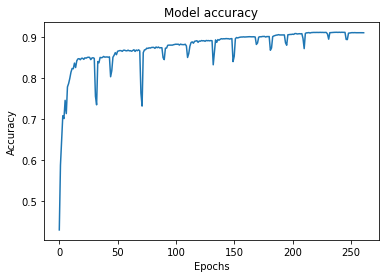

Got 38600451/38666240 with acc 99.83
Dice score: 0.9120025634765625


tensor(0.9120, device='cuda:0')

In [26]:
cpu_accuracy = [elem.cpu() for elem in accuracy]
x = np.arange(0, len(accuracy))
plt.title("Model accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(x, cpu_accuracy)
plt.show()
check_accuracy(val_loader, unet, device=DEVICE)

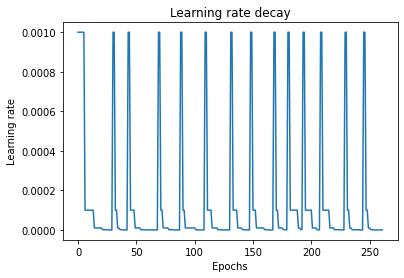

In [56]:
x = np.arange(0, len(learn_rate))
plt.title("Learning rate decay")
plt.xlabel("Epochs")
plt.ylabel("Learning rate")
plt.plot(x, learn_rate)
plt.show()

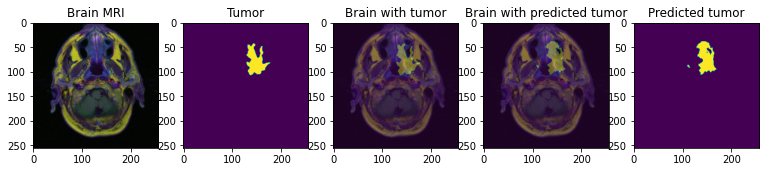

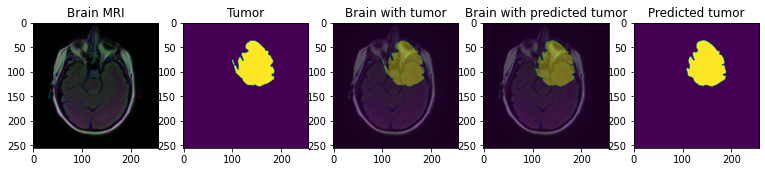

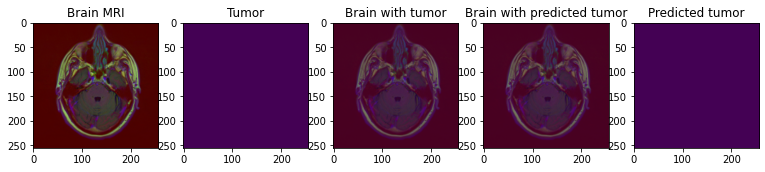

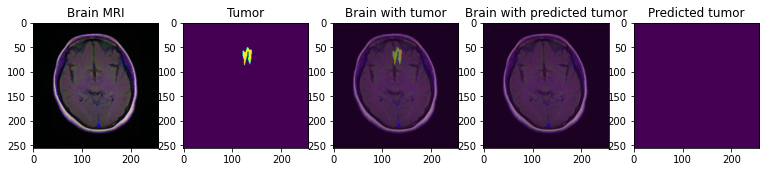

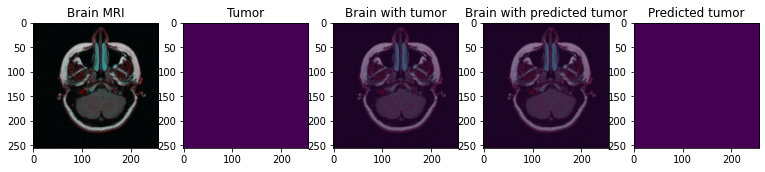

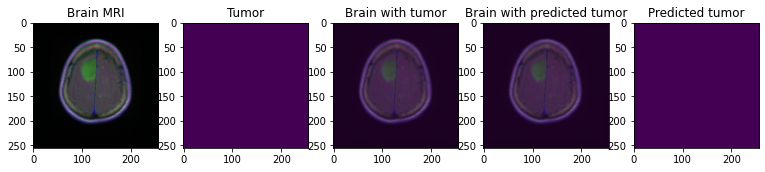

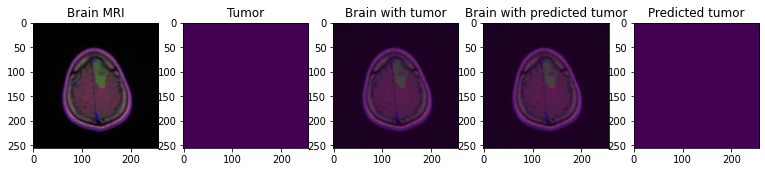

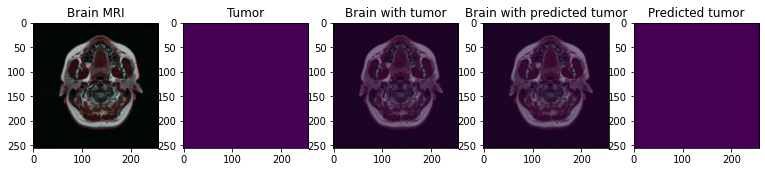

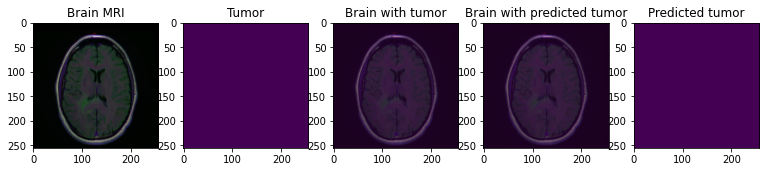

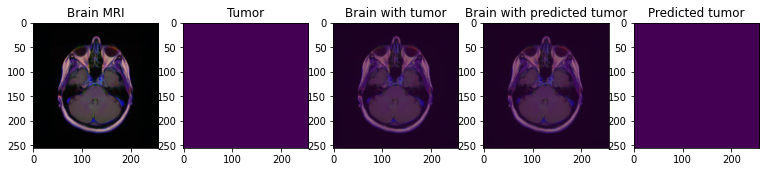

In [71]:
for i in range(10):
    plot_image(predictions, i)

In [29]:
check_accuracy(val_loader, unet, device=DEVICE)

Got 38600451/38666240 with acc 99.83
Dice score: 0.9120025634765625


tensor(0.9120, device='cuda:0')